# Loading Data

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#pip install nrclex
from nrclex import NRCLex
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import datetime
import re
import nltk
from textblob import TextBlob
nltk.download('vader_lexicon')
nltk.download('punkt')  # For tokenization
nltk.download('averaged_perceptron_tagger')# Required for NRCLex
from transformers import pipeline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheebamoghal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Basic Exploration

In [125]:
df = pd.read_csv('/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/data/csv/Merged_data.csv', delimiter=',', encoding='utf-8')

df.head(3)

,body,controversiality,created_utc,subreddit
0,I'd like to think I've dealt with cancer head ...,0,1719826058,CancerFamilySupport
1,thank you for pointing out how it’s misunderst...,0,1719799836,CrohnsDisease
2,It made me realise exactly how little I had. A...,0,1719847236,breastcancer


In [126]:
# checking for missing values
df.isna().sum()

body                0
controversiality    0
created_utc         0
subreddit           0
dtype: int64

In [127]:
#for i in df.columns:
#    print(df[i].unique())

print(df['subreddit'].unique())

print(df.dtypes)

# converting the time to datetime
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')  # Convert timestamp if necessary

['CancerFamilySupport' 'CrohnsDisease' 'breastcancer' 'thyroidcancer'
 'AskDocs' 'UlcerativeColitis' 'Autoimmune' 'BladderCancer'
 'doihavebreastcancer' 'Lymphedema' 'WomensHealth' 'ProstateCancer' 'cll'
 'Microbiome' 'predental' 'endometrialcancer' 'cancer' 'Hashimotos'
 'coloncancer' 'PreCervicalCancer' 'lymphoma' 'CancerCaregivers'
 'braincancer' 'publichealth' 'nursing' 'testicularcancer' 'lynchsyndrome'
 'HealthInsurance' 'Fuckcancer' 'BRCA' 'Cancersurvivors' 'Health'
 'leukemia' 'pancreaticcancer' 'skincancer' 'stomachcancer']
body                object
controversiality     int64
created_utc          int64
subreddit           object
dtype: object


In [128]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['body'] = df['body'].apply(preprocess_text)

df.head(2)

,body,controversiality,created_utc,subreddit
0,id like to think ive dealt with cancer head on...,0,2024-07-01 09:27:38,CancerFamilySupport
1,thank you for pointing out how its misundersto...,0,2024-07-01 02:10:36,CrohnsDisease


# Questions: 

## What is the sentiment distribution across these diverse healthcare subreddits?

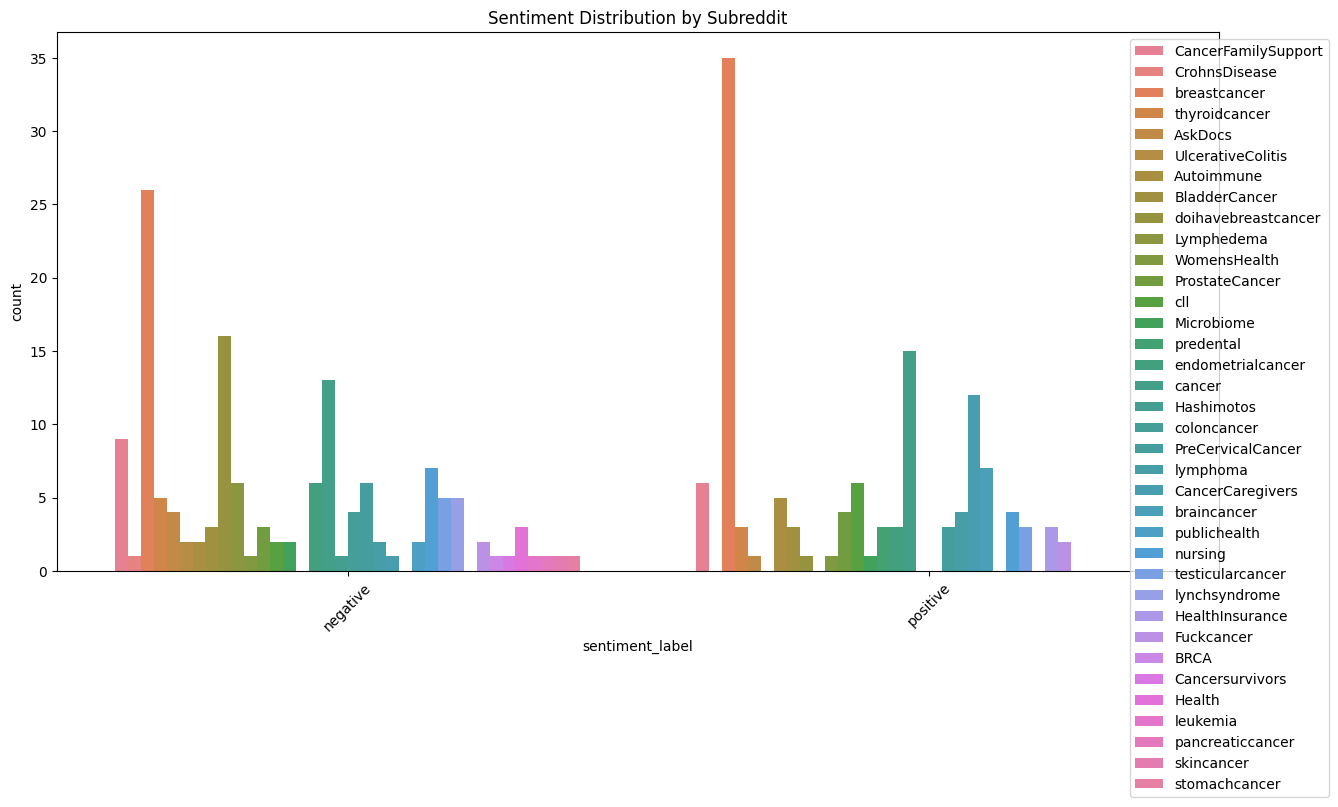

In [129]:
# Initialize Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['body'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

plt.figure(figsize=(15, 7))
sns.countplot(data=df, x='sentiment_label', hue='subreddit')
plt.title('Sentiment Distribution by Subreddit')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
plt.show()

## Which emotions are most common in specific healthcare communities?

Used three approaches here.

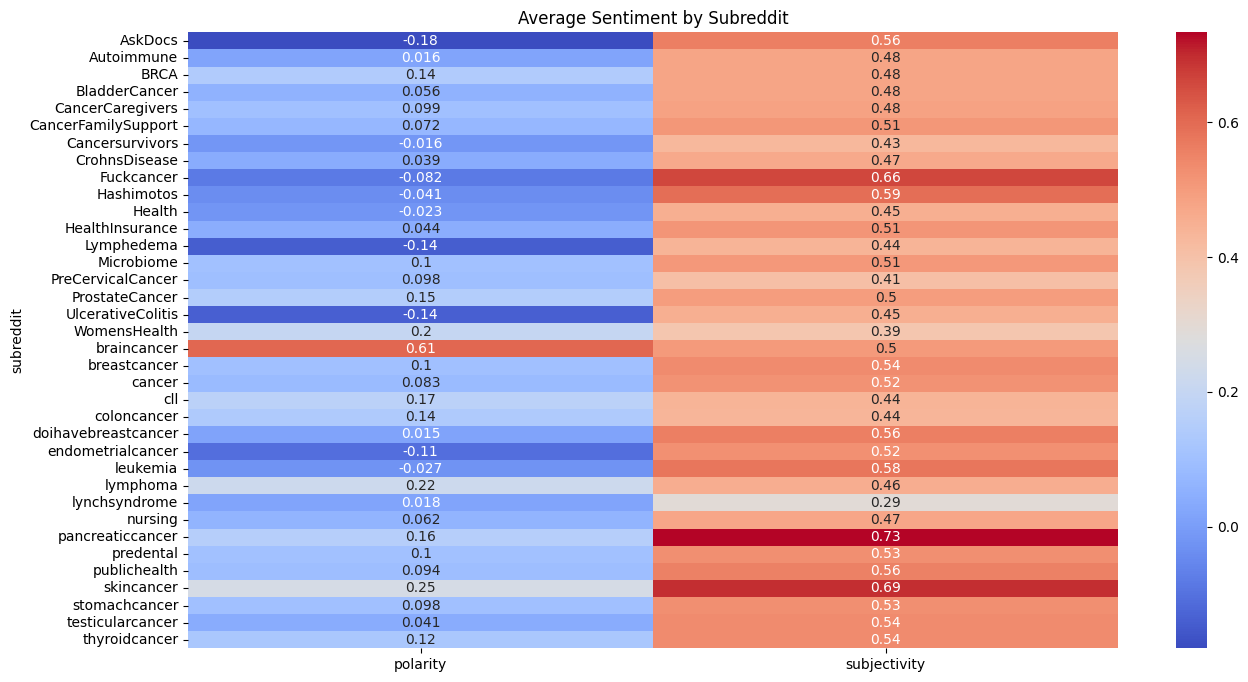

In [130]:
# using textblob for sentiment analysis as a proxy for emotion

def get_sentiment(text):
    blob = TextBlob(text)
    return {
        'polarity': blob.sentiment.polarity,       # -1 (negative) to 1 (positive)
        'subjectivity': blob.sentiment.subjectivity # 0 (objective) to 1 (subjective)
    }

sentiment_df = pd.DataFrame(df['body'].apply(get_sentiment).tolist())
sentiment_df['subreddit'] = df['subreddit']
sentiment_avg = sentiment_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(sentiment_avg, annot=True, cmap='coolwarm')
plt.title('Average Sentiment by Subreddit')
plt.show()


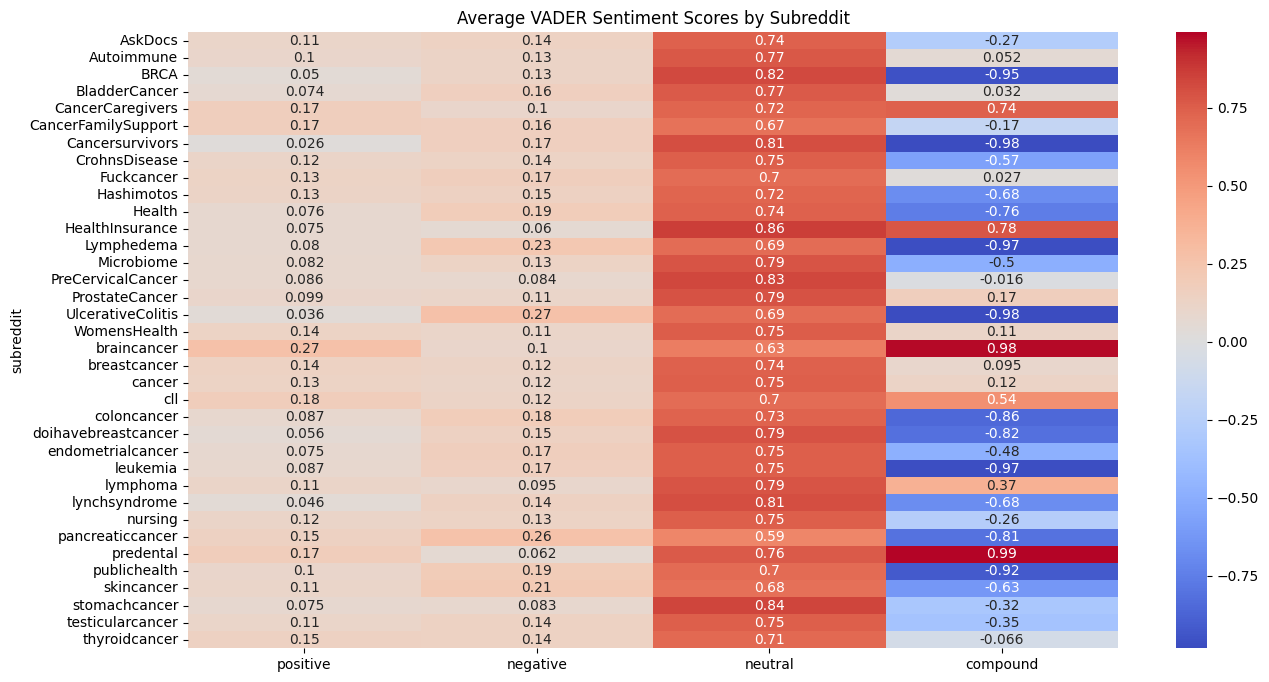

In [131]:
# using vader for emotional scoring

# VADER
sid = SentimentIntensityAnalyzer()

def get_vader_scores(text):
    scores = sid.polarity_scores(text)
    return {
        'positive': scores['pos'],
        'negative': scores['neg'],
        'neutral': scores['neu'],
        'compound': scores['compound']
    }

vader_df = pd.DataFrame(df['body'].apply(get_vader_scores).tolist())
vader_df['subreddit'] = df['subreddit']
vader_avg = vader_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(vader_avg, annot=True, cmap='coolwarm')
plt.title('Average VADER Sentiment Scores by Subreddit')
plt.show()


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/Users/sheebamoghal/Desktop/courses/DSAN 6000/fall-2024-project-team-35/cancer/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


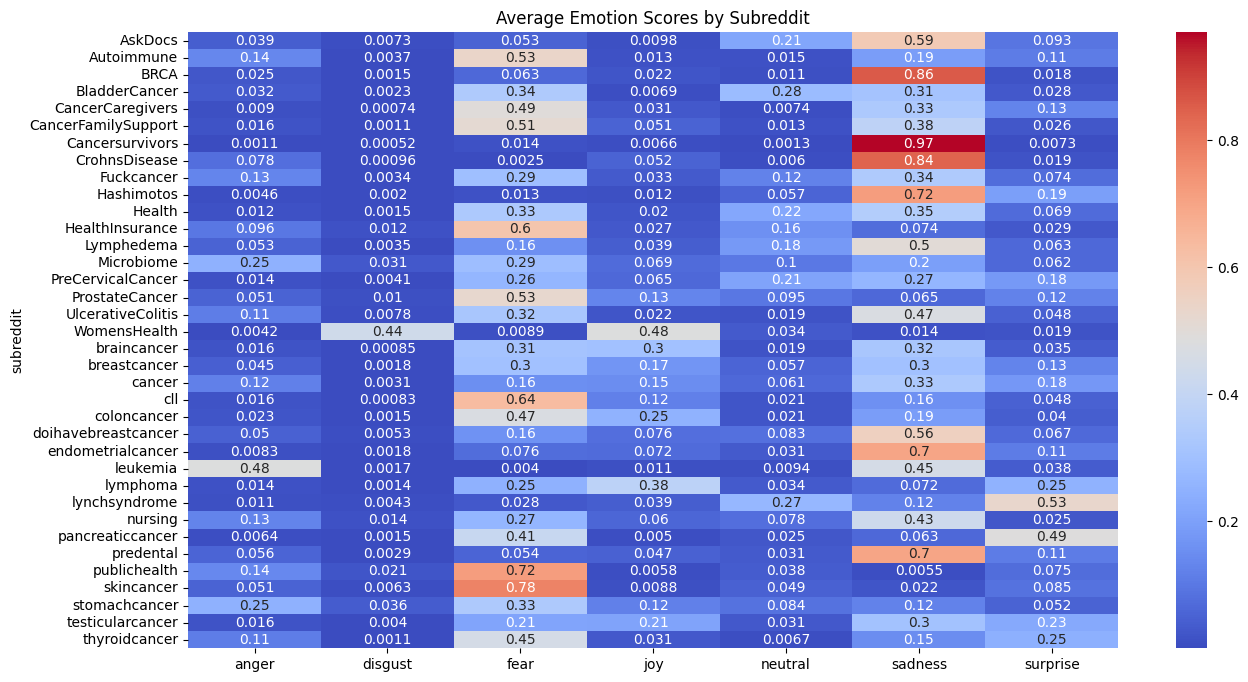

In [132]:
# using pretained transformeers model

MAX_LENGTH = 512

def truncate_text(text, max_length=MAX_LENGTH):
    tokens = text.split()  # Tokenize by whitespace
    if len(tokens) > max_length:
        text = ' '.join(tokens[:max_length])
    return text

#df['truncated_body'] = df['body'].apply(lambda x: truncate_text(x))

# loading a pretrained emotion classification model
emotion_classifier = pipeline(
    "text-classification", 
    model="j-hartmann/emotion-english-distilroberta-base", 
    return_all_scores=True, 
    truncation=True
)
def get_emotions_transformers(text):
    emotion_scores = emotion_classifier(text)[0]  # emootional scores
    # converting these list of scores to a dictionary
    return {item['label']: item['score'] for item in emotion_scores}

emotion_df = pd.DataFrame(df['body'].apply(get_emotions_transformers).tolist())
emotion_df['subreddit'] = df['subreddit']
emotion_avg = emotion_df.groupby('subreddit').mean()

plt.figure(figsize=(15, 8))
sns.heatmap(emotion_avg, annot=True, cmap='coolwarm')
plt.title('Average Emotion Scores by Subreddit')
plt.show()


## What are the primary topics or themes discussed in each subreddit?

In [133]:
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = vectorizer.fit_transform(df['body'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# topic modeling using LDA 
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic 1:
['people', 'able', 'things', 'dont', 'understand', 'prostate', 'radiation', 'medicine', 'like', 'im']
Topic 2:
['need', 'feeling', 'doctors', 'dont', 'lump', 'right', 'people', 'im', 'just', 'did']
Topic 3:
['dont', 'people', 'just', 'like', 'im', 'care', 'things', 'treatment', 'know', 'need']
Topic 4:
['lot', 'pain', 'diagnosed', 'like', 'im', 'just', 'mom', 'know', 'dad', 'time']
Topic 5:
['dont', 'blood', 'life', 'didnt', 'port', 'time', 'body', 'im', 'days', 'chemo']


## Are certain subreddits more likely to express interpersonal conflict or emotional support?

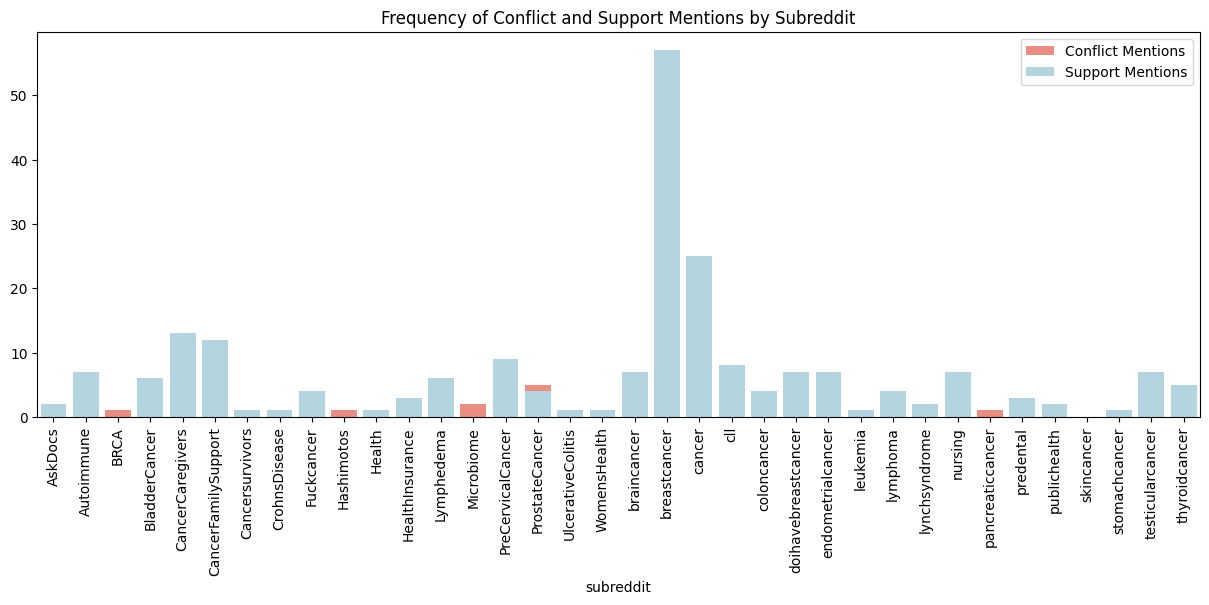

In [134]:
conflict_keywords = [
    "frustration", "disappointment", "anger", "resentment", "annoyance", "conflict", 
    "tension", "irritation", "betrayal", "arguments", "struggle", "stress", 
    "misunderstanding", "criticism", "blame", "guilt", "hostility", "resent", 
    "unhappy", "sadness", "upset", "hurt", "fighting", "argument", "tough", 
    "challenging", "difficulty", "pressure", "discouragement", "despair", 
    "fear", "helplessness", "hopelessness", "loss", "disapproval", "rejection", 
    "grief", "pain", "suffering", "alienation", "abandonment", "desperation", 
    "friction", "dispute", "distrust", "confusion", "embarrassment", "injustice", 
    "unfair", "isolation", "loneliness", "agitation", "disgust", "irritability", 
    "exclusion", "condemnation", "bitterness", "exasperation", "discontent", 
    "jealousy", "envy", "regret", "doubt", "turmoil", "burden", "anxiety", 
    "pressure", "insecurity", "worry", "distress", "disillusionment", "strife", 
    "unresolved", "torment", "persecution", "victimization", "abrasiveness", 
    "defiance", "rebellion", "protest", "contempt", "accusation", "attack", 
    "judgment", "exclusion", "neglect", "withdrawal", "abuse", "mockery", "clash"
] # added more words to balance the viz

support_keywords = [
    "support", "help", "care", "encourage", "comfort", "kindness", "understanding", 
    "compassion", "empathy", "assistance", "guidance", "backing", "aid", "uplifting", 
    "positive", "friendship", "community", "reassurance", "sympathy", "solidarity", 
    "together", "listening", "patience", "trust", "love", "appreciation", "encouragement", 
    "advice", "warmth", "respect", "hope", "motivating", "strength", "connection"
]

df['conflict_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in conflict_keywords))
df['support_mention'] = df['body'].apply(lambda x: any(keyword in x for keyword in support_keywords))

conflict_counts = df.groupby('subreddit')['conflict_mention'].sum()
support_counts = df.groupby('subreddit')['support_mention'].sum()

plt.figure(figsize=(15, 5))
sns.barplot(x=conflict_counts.index, y=conflict_counts.values, color='salmon', label='Conflict Mentions')
sns.barplot(x=support_counts.index, y=support_counts.values, color='lightblue', label='Support Mentions')
plt.title('Frequency of Conflict and Support Mentions by Subreddit')
plt.xticks(rotation=90)
plt.legend()
plt.show()


## How does sentiment vary over time within different healthcare communities?

In [135]:
df['date'] = df['created_utc'].dt.date
#print(df['date'].unique()) # so didnt work so can we expand the data? 

## What is the average sentiment score?

<Figure size 1500x800 with 0 Axes>

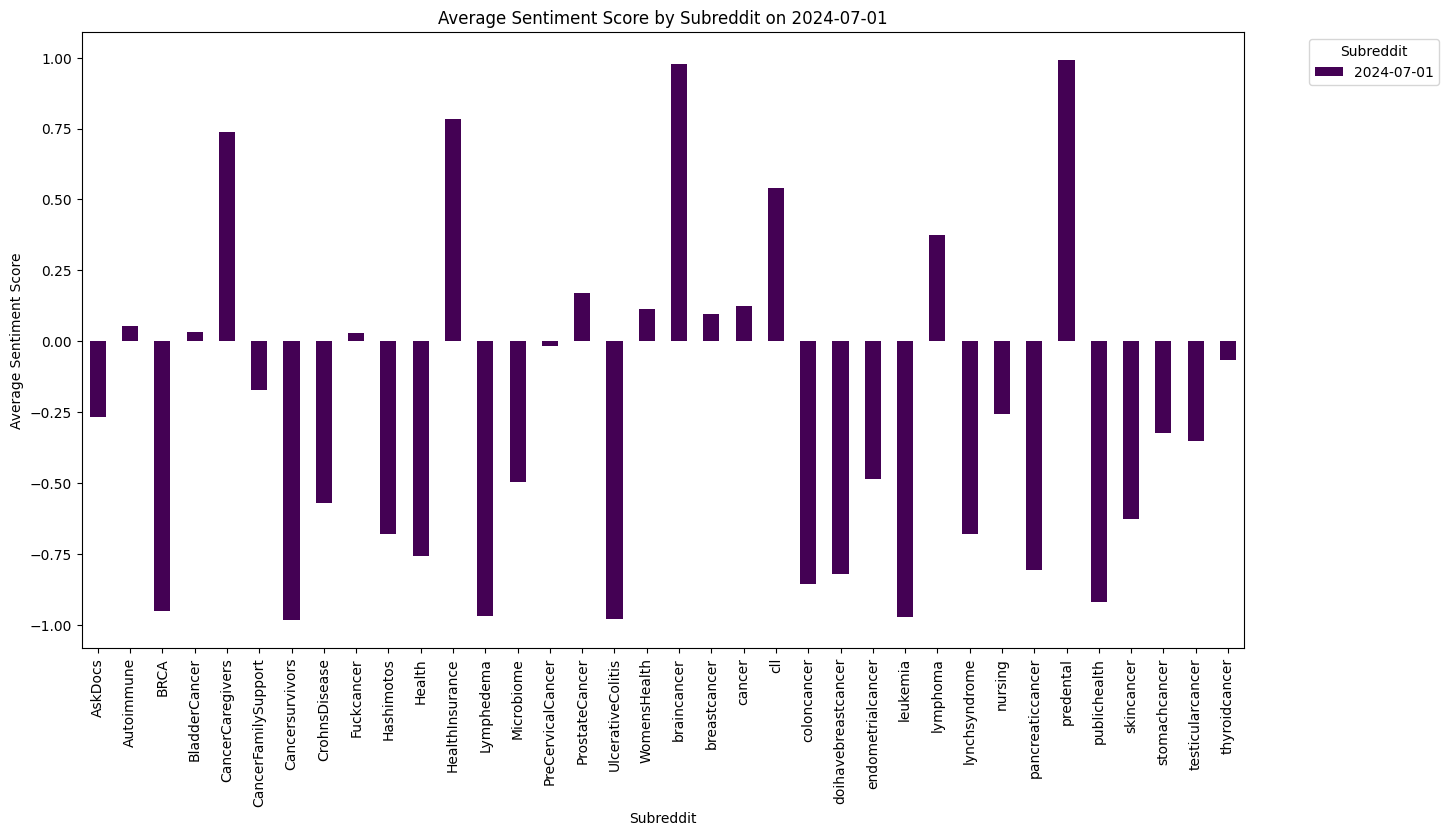

In [136]:
daily_sentiment = df.groupby(['date', 'subreddit'])['sentiment_score'].mean().unstack()
plt.figure(figsize=(15, 8))
daily_sentiment.T.plot(kind='bar', figsize=(15, 8), colormap="viridis")
plt.title('Average Sentiment Score by Subreddit on {}'.format(daily_sentiment.index[0]))
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.legend(title="Subreddit", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## How is the sentiment score distribution?

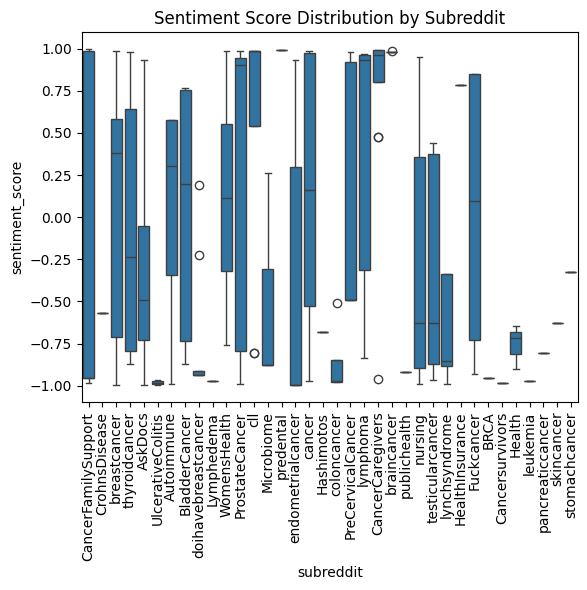

In [137]:
sns.boxplot(data=df, x='subreddit', y='sentiment_score')
plt.xticks(rotation=90)
plt.title('Sentiment Score Distribution by Subreddit')
plt.show()


## Is there any association between the comment length and the sentiment?

That is, do people that type more face a similar form of emotion? 

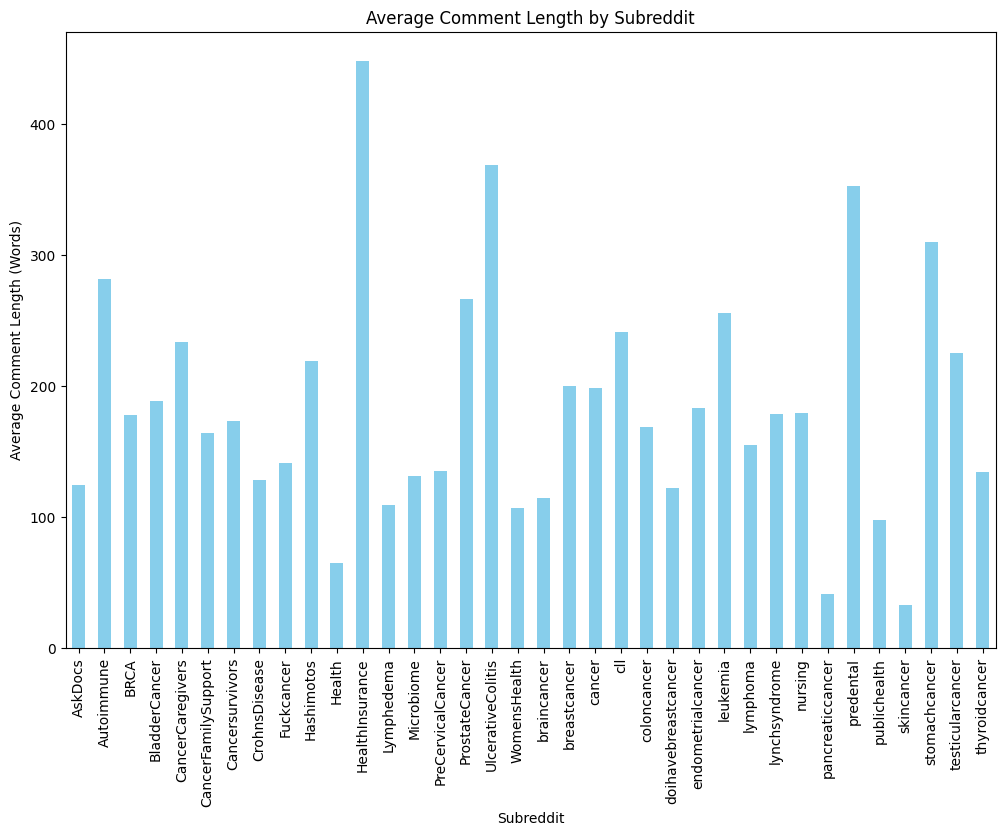

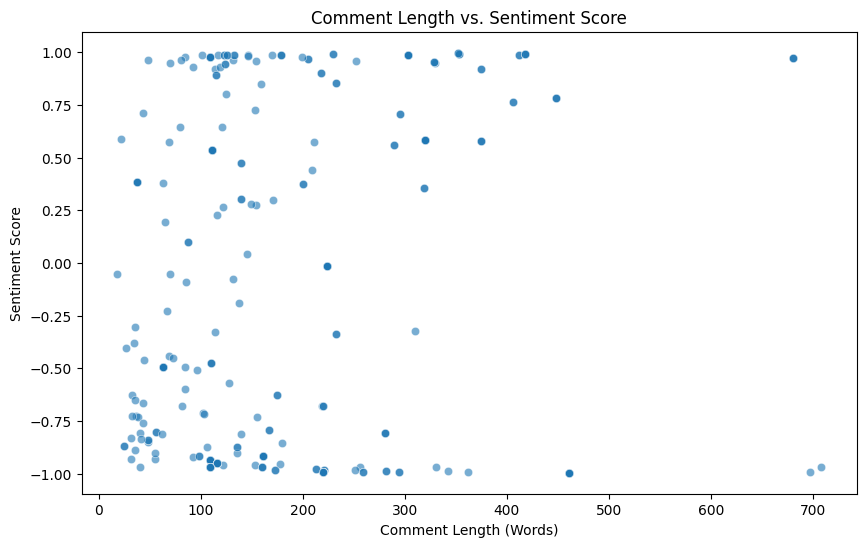

In [138]:
# lengh of comments
df['comment_length'] = df['body'].apply(lambda x: len(x.split()))

# avg comment length by subreddit
avg_length_per_subreddit = df.groupby('subreddit')['comment_length'].mean()


plt.figure(figsize=(12, 8))
avg_length_per_subreddit.plot(kind='bar', color='skyblue')
plt.title('Average Comment Length by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Comment Length (Words)')
plt.xticks(rotation=90)
plt.show()

# comment length vs. sentiment score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='comment_length', y='sentiment_score', alpha=0.6)
plt.title('Comment Length vs. Sentiment Score')
plt.xlabel('Comment Length (Words)')
plt.ylabel('Sentiment Score')
plt.show()


## How does the engagement differ across different subreddits?

**Note**: Using 'controversiality' and 'mentions' as placeholders. Let me know if this works! 

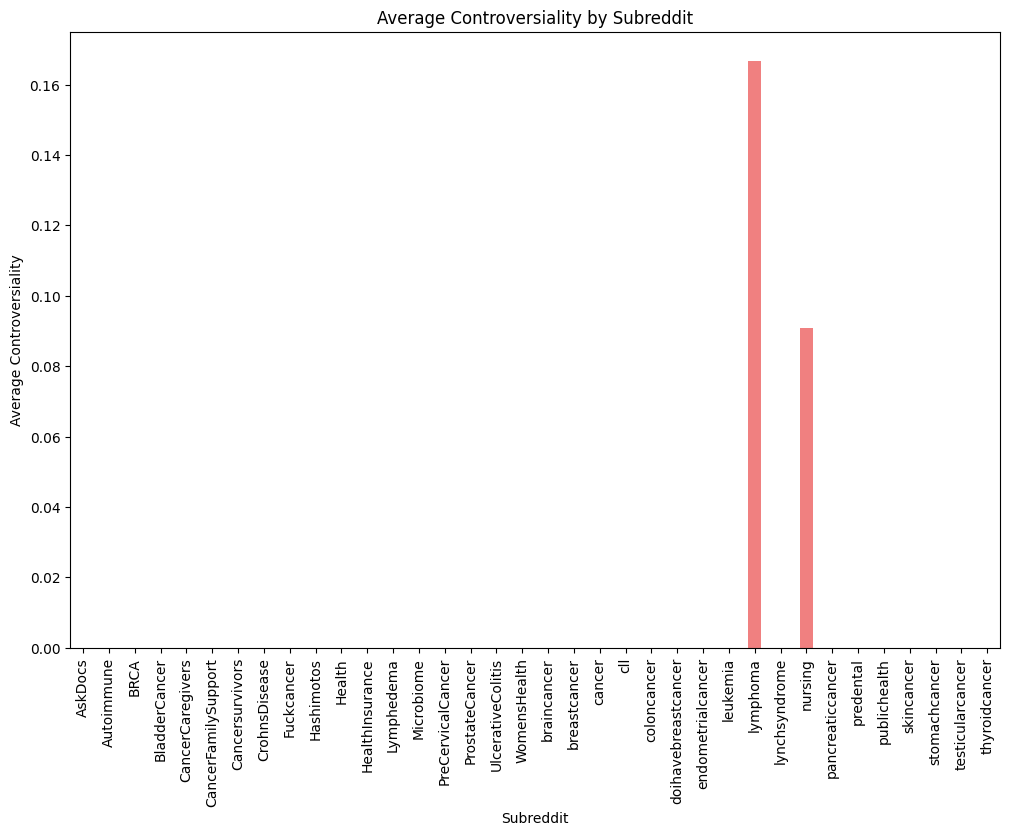

In [139]:
# avg controversiality per subreddit
avg_controversiality_per_subreddit = df.groupby('subreddit')['controversiality'].mean()
plt.figure(figsize=(12, 8))
avg_controversiality_per_subreddit.plot(kind='bar', color='lightcoral')
plt.title('Average Controversiality by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Controversiality')
plt.xticks(rotation=90)
plt.show()


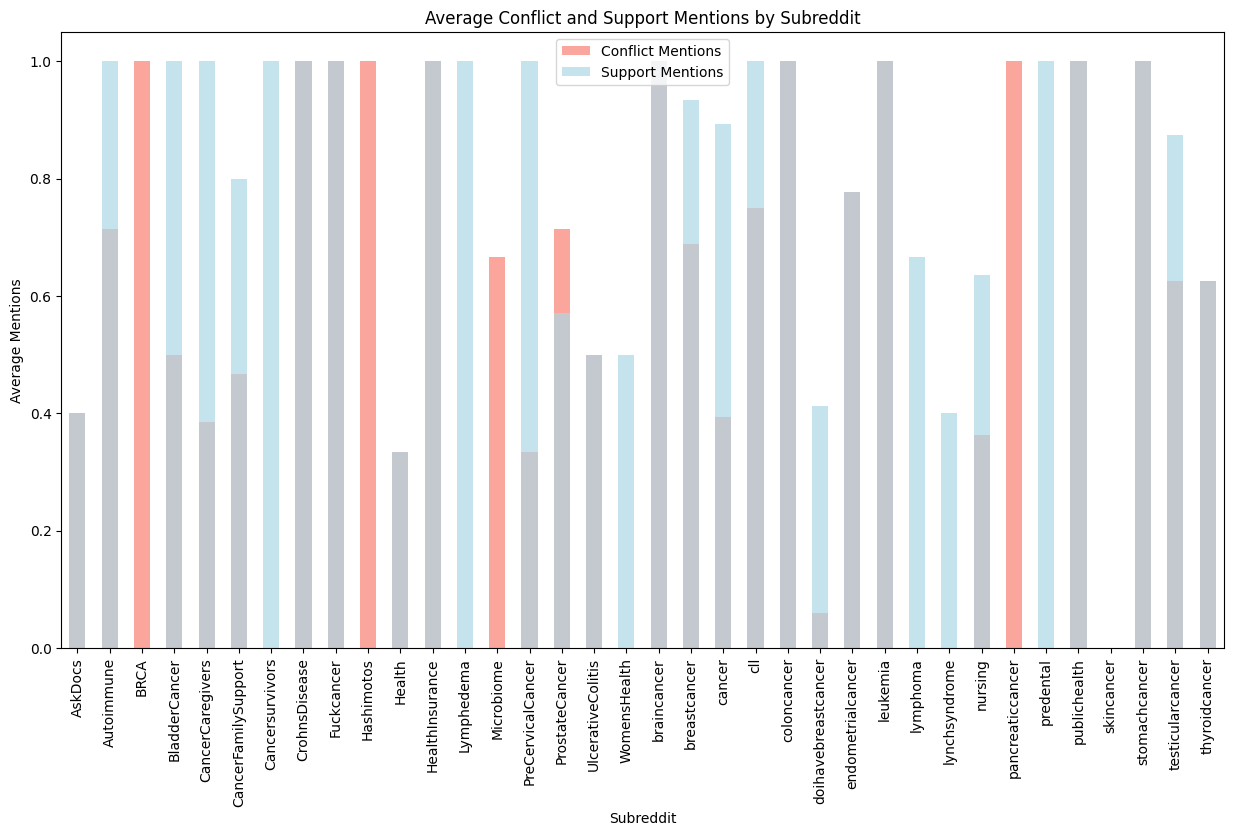

In [140]:
# avg frequency of conflict and support mentions per subreddit
conflict_counts = df.groupby('subreddit')['conflict_mention'].mean()
support_counts = df.groupby('subreddit')['support_mention'].mean()
plt.figure(figsize=(15, 8))
conflict_counts.plot(kind='bar', color='salmon', alpha=0.7, label='Conflict Mentions')
support_counts.plot(kind='bar', color='lightblue', alpha=0.7, label='Support Mentions')
plt.title('Average Conflict and Support Mentions by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Mentions')
plt.xticks(rotation=90)
plt.legend()
plt.show()


## What are the most common words or phrases for positive versus negative comments?

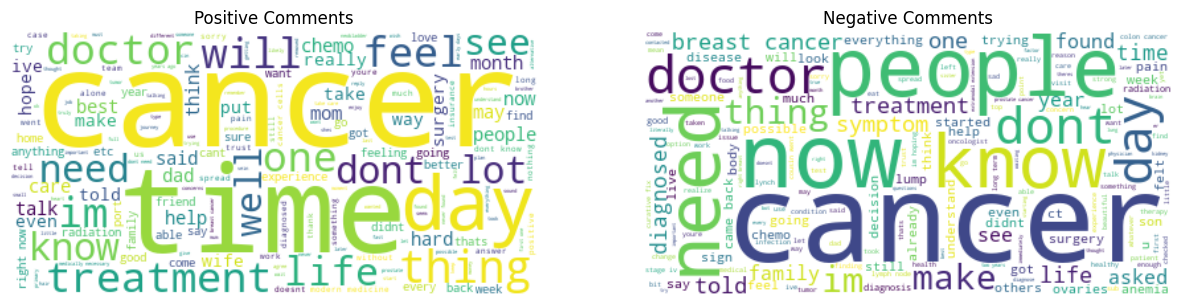

In [141]:
# positive vs negative
positive_comments = ' '.join(df[df['sentiment_score'] > 0]['body'])
negative_comments = ' '.join(df[df['sentiment_score'] < 0]['body'])


plt.figure(figsize=(15, 7))

# positive
plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color='white').generate(positive_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Comments')

# negative
plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color='white').generate(negative_comments)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Comments')

plt.show()


## Are there specific times of day or days of the week when users discuss certain emotions more frequently?

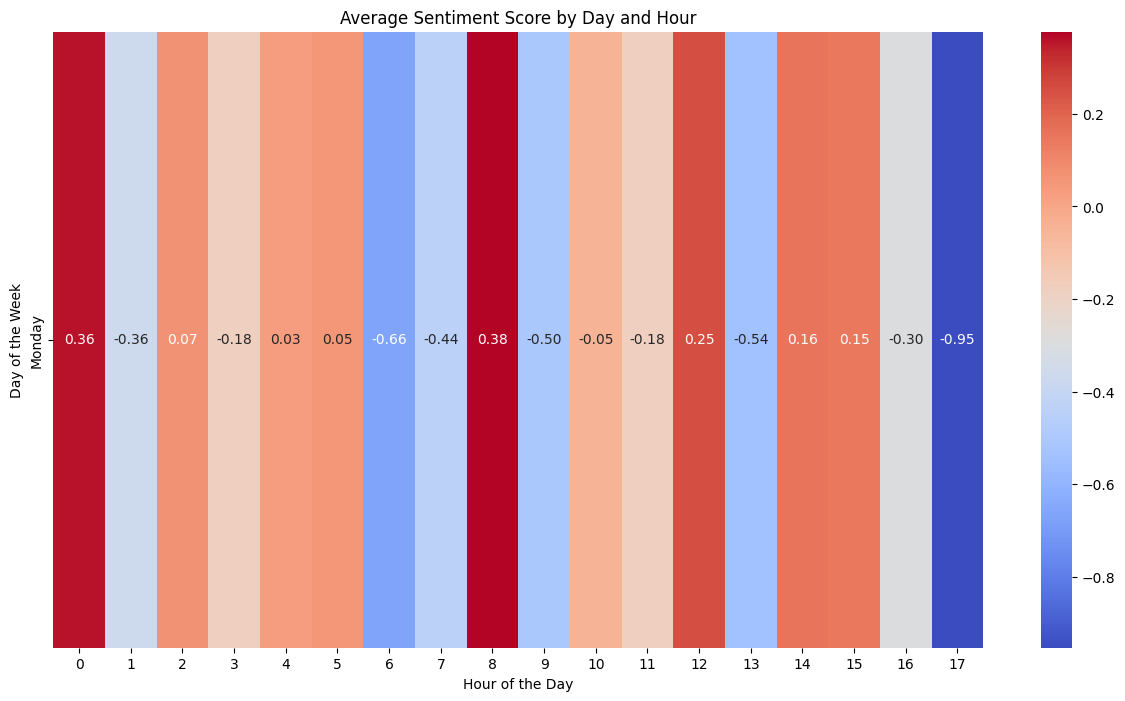

In [142]:
# day of the week and hour extraction
df['day_of_week'] = df['created_utc'].dt.day_name()
df['hour'] = df['created_utc'].dt.hour

#  verage sentiment score by day of week and hour
emotion_by_time = df.groupby(['day_of_week', 'hour'])['sentiment_score'].mean().unstack()

# heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(emotion_by_time, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average Sentiment Score by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()


## Is there a difference in sentiment or emotion between users who post frequently versus those who post infrequently?

Since we don’t have unique user IDs, we can use comment length as an indirect measure. Longer comments may indicate more engaged or frequent participants, while shorter comments might suggest less engaged users.

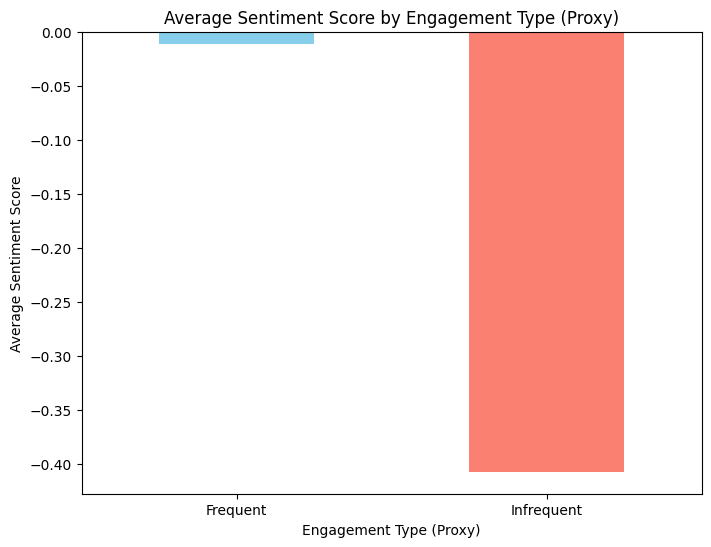

In [143]:
# comment length in terms of word count
df['comment_length'] = df['body'].apply(lambda x: len(x.split()))

# comment length threshold (e.g., more than 50 words as 'detailed' but can edit this
df['engagement_type'] = df['comment_length'].apply(lambda x: 'Frequent' if x > 50 else 'Infrequent')

# average sentiment score by engagement type
avg_sentiment_engagement = df.groupby('engagement_type')['sentiment_score'].mean()
plt.figure(figsize=(8, 6))
avg_sentiment_engagement.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Sentiment Score by Engagement Type (Proxy)')
plt.xlabel('Engagement Type (Proxy)')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()


## Do specific healthcare-related terms or topics (e.g., “treatment,” “diagnosis,” “insurance”) correlate with particular emotions?

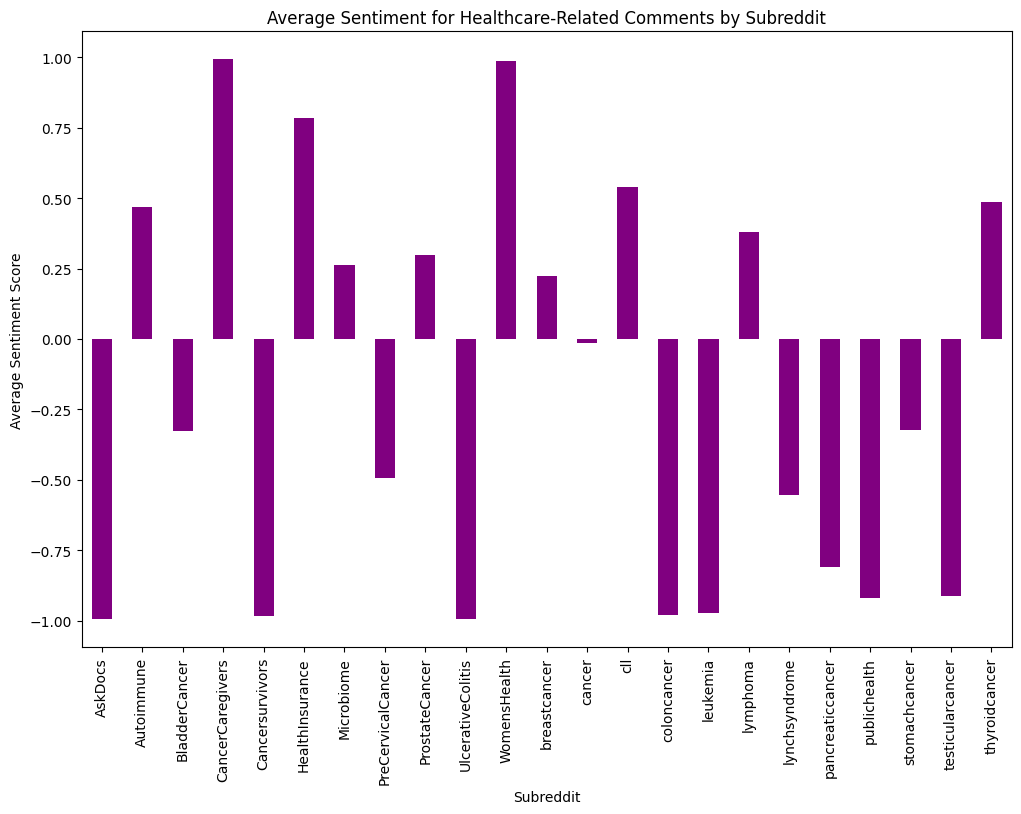

In [144]:
# filtweing comments with healthcare terms 
healthcare_terms = ["treatment", "diagnosis", "insurance"] # can edit this
df['mentions_healthcare'] = df['body'].apply(lambda x: any(term in x.lower() for term in healthcare_terms))

# average sentiment score for comments mentioning healthcare terms
avg_emotion_healthcare = df[df['mentions_healthcare']].groupby('subreddit')['sentiment_score'].mean()
plt.figure(figsize=(12, 8))
avg_emotion_healthcare.plot(kind='bar', color='purple')
plt.title('Average Sentiment for Healthcare-Related Comments by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=90)
plt.show()


## What are the most common expressions of gratitude, frustration, or hope?

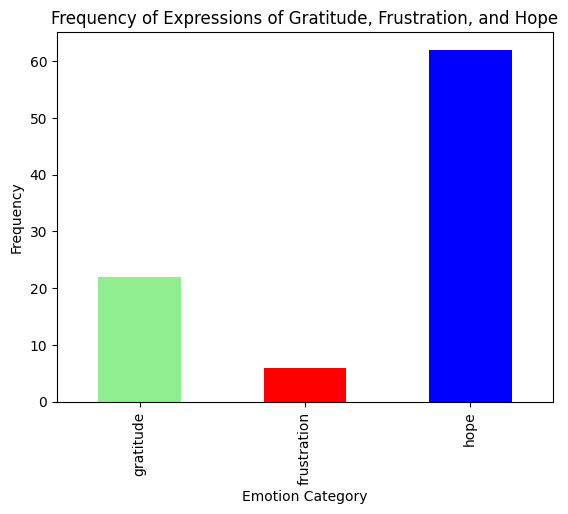

In [145]:
# keywords for each emotion category

# EDITABLE 
gratitude_keywords = ["thank you", "thanks", "appreciate"]
frustration_keywords = ["frustrated", "annoyed", "disappointed"]
hope_keywords = ["hope", "optimistic", "wish"]

df['gratitude'] = df['body'].apply(lambda x: any(word in x.lower() for word in gratitude_keywords))
df['frustration'] = df['body'].apply(lambda x: any(word in x.lower() for word in frustration_keywords))
df['hope'] = df['body'].apply(lambda x: any(word in x.lower() for word in hope_keywords))
emotion_counts = df[['gratitude', 'frustration', 'hope']].sum()
emotion_counts.plot(kind='bar', color=['lightgreen', 'red', 'blue'])
plt.title('Frequency of Expressions of Gratitude, Frustration, and Hope')
plt.xlabel('Emotion Category')
plt.ylabel('Frequency')
plt.show()


## Are there differences in the types of issues discussed by new users versus long-time users?
need userid????

## What are the patterns of conversation in highly controversial versus non-controversial comments?

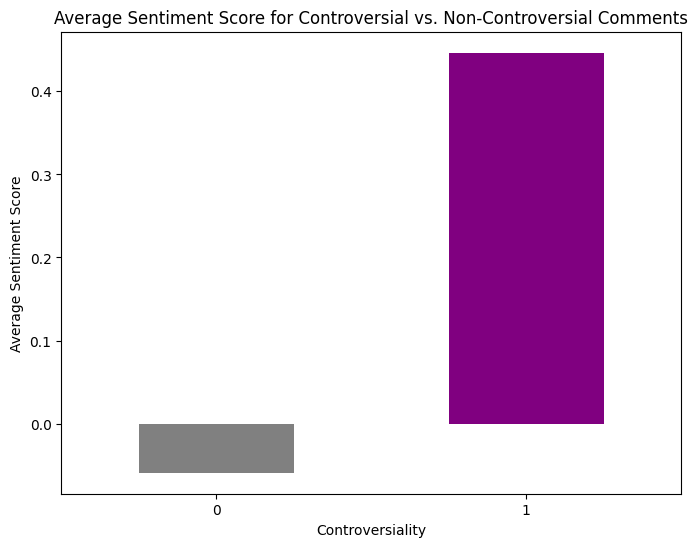

In [146]:
# avg sentiment for controversial vs. non-controversial comments
avg_sentiment_controversial = df.groupby('controversiality')['sentiment_score'].mean()
plt.figure(figsize=(8, 6))
avg_sentiment_controversial.plot(kind='bar', color=['gray', 'purple'])
plt.title('Average Sentiment Score for Controversial vs. Non-Controversial Comments')
plt.xlabel('Controversiality')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()


## How do emotional responses change when users discuss their own health experiences versus others’ experiences?

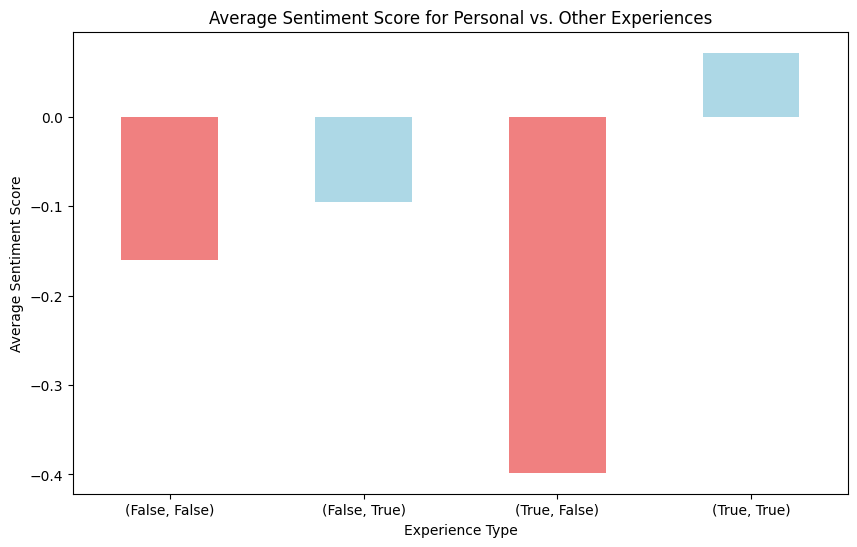

In [147]:
# using "my" and "your" personal and other-focused comments
df['personal_experience'] = df['body'].apply(lambda x: "i " in x.lower() or "my " in x.lower())
df['other_experience'] = df['body'].apply(lambda x: "you " in x.lower() or "your " in x.lower())

# avg sentiment for personal vs. other experiences
avg_sentiment_experience = df.groupby(['personal_experience', 'other_experience'])['sentiment_score'].mean()
plt.figure(figsize=(10, 6))
avg_sentiment_experience.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Average Sentiment Score for Personal vs. Other Experiences')
plt.xlabel('Experience Type')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=0)
plt.show()
